# Architecture Revision 2

Previously, there was code duplication between the different incremental coefficient optimisers. Here is another integration attempt with the aim to be more granular procedural approach. Key components:

1. Core state objects with extended specs to simulate inheritance, base fields (`x`, `coeff`, `max_features`, `current_features`, `intercept`), for regression additionally (`gramian`, `cholesky`)
2. Reusable functions `add_column` and `add_column_sparse`. Alternatively, since this was also flagged as a potential performance overhead, we consider augmenting the propositionalisation class to write directly into a buffer!
3. Functions `minimum_logistic_loss_coefs` and `minimum_squared_loss_coeffs`
4. Bound together by a higher order function `gradient_sum_boosting_ensemble`


## Test Data

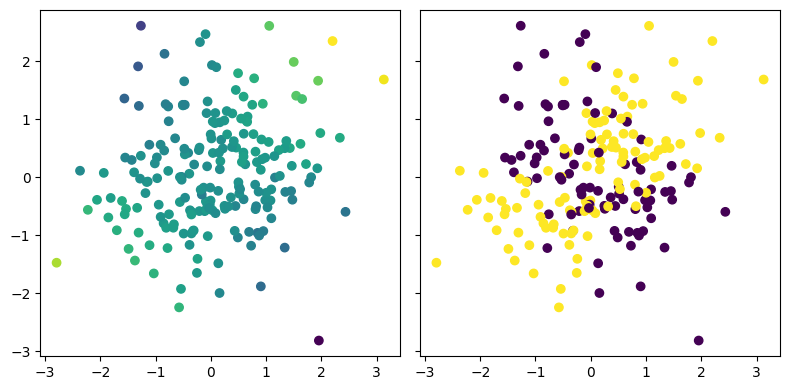

In [4]:
import numpy as np
from scipy.special import expit
from matplotlib import pyplot as plt

RNG = np.random.default_rng(0)

cov = np.array(
    [[1, 0.2], 
     [0.2, 1]]
)

n = 200
x = RNG.multivariate_normal([0, 0], cov, size=n)
y_regr = x[:, 0] * x[:, 1] + RNG.normal(scale=0.25, size=n)
y_class = RNG.binomial(n=1, p=expit(4 * x[:, 0] * x[:, 1]))

_, axs = plt.subplots(1, 2, figsize=(8, 4), sharey=True, tight_layout=True)
axs[0].scatter(x[:, 0], x[:, 1], c=y_regr)
axs[1].scatter(x[:, 0], x[:, 1], c=y_class)
plt.show()

## Base Boosting Function and Simple Regression Case

In [96]:
import numpy as np
from numba import int64, float64, boolean, njit
from numba.experimental import jitclass
from optikon import max_weighted_support, equal_width_propositionalization
from numba.typed import List

regression_spec_spec = [
    ('y', float64[:]),
    ('x', float64[:, :]),
    ('max_features', int64),
    ('intercept', boolean),
    ('lam', float64)
]

state_spec = [
    ('phi', float64[:, :]),
    ('coef', float64[:]),
    ('current_features', int64),
]

@jitclass(regression_spec_spec)
class RegressionSpec:
    def __init__(self, y, x, max_features, intercept, lam):
        self.y = y
        self.x = x
        self.max_features = max_features
        self.intercept = intercept
        self.lam = lam

@jitclass(state_spec)
class BoostingState:
    def __init__(self, phi, coef, current_features):
        self.phi = phi
        self.coef = coef
        self.current_features = current_features

    @staticmethod
    def from_spec(spec):
        phi = np.zeros(shape=(len(spec.y), spec.max_features+spec.intercept))
        coef = np.zeros(spec.max_features+spec.intercept)
        current_features = 0
        return BoostingState(phi, coef, current_features)

@njit
def gradient_least_squares(spec, state):
    return state.phi[:, :state.current_features].dot(state.coef[:state.current_features]) - spec.y

@njit
def fit_least_squares_coefficients(spec, state):
    gramian = state.phi[:, :state.current_features].T.dot(state.phi[:, :state.current_features])

    if spec.lam > 0:
        for i in range(spec.intercept, state.current_features):
            gramian[i, i] += spec.lam
        
    state.coef[:state.current_features] = np.linalg.solve(gramian, state.phi[:, :state.current_features].T.dot(spec.y))

@njit
def gradient_sum_rule_ensemble(spec, state, props, fit_function, gradient_function, max_depth=5):
    qs = List()
    if spec.intercept:
        qs.append(props[0:0]) 
        state.phi[:, state.current_features] = 1
        state.current_features += 1
        fit_function(spec, state)
        
    for _ in range(spec.max_features):
        g = gradient_function(spec, state)

        opt_key_pos, opt_val_pos, _, _ = max_weighted_support(spec.x, g, props, max_depth)
        opt_key_neg, opt_val_neg, _, _ = max_weighted_support(spec.x, -g, props, max_depth)
        if opt_val_pos >= opt_val_neg:
            qs.append(props[opt_key_pos])
        else:
            qs.append(props[opt_key_neg])

        state.phi[qs[-1].support_all(spec.x), state.current_features] = 1
        state.current_features += 1

        fit_function(spec, state)
    return state.coef, qs

spec = RegressionSpec(y_regr, x, 3, False, 0.0)
state = BoostingState.from_spec(spec) # init_state(spec)
coefs, rules = gradient_sum_rule_ensemble(spec, state, equal_width_propositionalization(spec.x), fit_least_squares_coefficients, gradient_least_squares)
for coef, rule in zip(coefs, rules):
    print(coef, rule.str_from_conj(np.arange(len(rule))))


1.5036582513481511 x1 >= 0.006 & x2 >= 0.059
-0.8914385667003335 x1 >= -1.864 & x1 <= 1.388 & x2 >= 0.352
0.6744745663809992 x1 <= 0.006 & x2 <= 0.881


## Instantiation for Classification

In [ ]:
classification_spec_spec = [
    ('y', int64[:]),
    ('x', float64[:, :]),
    ('max_features', int64),
    ('intercept', boolean),
    ('lam', float64),
    ('max_iter', int64),
    ('tol', float64)
]

@jitclass(classification_spec_spec)
class ClassificationSpec:
    def __init__(self, y, x, max_features, intercept, lam):
        self.y = y
        self.x = x
        self.max_features = max_features
        self.intercept = intercept
        self.lam = lam
        self.max_iter=100
        self.tol=1e-6

cspec = ClassificationSpec(y_class, x, 3, False, 0.0)
cstate = BoostingState.from_spec(cspec)

@njit
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

@njit
def gradient_logistic_loss(spec, state):
    return sigmoid(state.phi[:, :state.current_features].dot(state.coef[:state.current_features])) - spec.y

@njit
def fit_min_logistic_loss_coefs(spec, state):
    phi = state.phi[:, :state.current_features]
    _, d = phi.shape
    beta = state.coef[:d] # np.zeros(d)
    
    for _ in range(spec.max_iter):
        p = sigmoid(phi.dot(beta))
        grad = phi.T @ (p - spec.y) + 2 * spec.lam * beta
        s = p * (1 - p)
        h = phi.T @ (phi * s[:, None]) + 2 * spec.lam * np.eye(d)
        delta = np.linalg.solve(h, grad)
        beta -= delta
        if np.linalg.norm(delta) < spec.tol:
            break

coefs, rules = gradient_sum_rule_ensemble(cspec, cstate, equal_width_propositionalization(spec.x), fit_min_logistic_loss_coefs, gradient_logistic_loss)

for coef, rule in zip(coefs, rules):
    print(coef, rule.str_from_conj(np.arange(len(rule))))


3.0618651491190616 x1 >= 0.006 & x2 >= 0.059
-1.9654415989393093 x1 >= -1.864 & x1 <= 0.923 & x2 >= 0.352
1.4055562089657432 x1 <= 0.006 & x2 <= 0.470


## Instantiation for Incremental Regression Weight Fitting

In [ ]:
import numpy as np
from numba import njit

incremental_ls_spec = [*state_spec,
    ('gram', float64[:, :]),
    ('chol', float64[:, :]),
]

@jitclass(incremental_ls_spec)
class IncrementalLeastSquaresBoostingState:
    def __init__(self, phi, coef, current_features, gram, chol):
        self.phi = phi
        self.coef = coef
        self.current_features = current_features
        self.gram = gram
        self.chol = chol

    @staticmethod
    def from_spec(spec):
        p = spec.max_features+spec.intercept
        phi = np.zeros(shape=(len(spec.y), p))
        g =  np.zeros((p, p))
        l = np.zeros((p, p))
        coef = np.zeros(p)
        current_features = 0
        return IncrementalLeastSquaresBoostingState(phi, coef, current_features, g, l)

state_incr = IncrementalLeastSquaresBoostingState.from_spec(spec)
print(state_incr)

@njit
def fit_minimum_squared_loss_coefs_incrementally(spec, state):
    x, y = state.phi, spec.y
    g, l = state.gram, state.chol
    coef = state.coef[:state.current_features]
    j = state.current_features - 1

    # Update Gramian
    g[j, :j] = x[:, :j].T @ x[:, j]
    g[:j, j] = g[j, :j]
    g[j, j] = x[:, j] @ x[:, j]

    if j!=0 or not spec.intercept:
        g[j, j] += spec.lam

    # Compute RHS
    b = np.zeros(j + 1)
    for i in range(j + 1):
        b[i] = x[:, i] @ y

    # Cholesky update: compute row j of l
    for k in range(j):
        s = 0.0
        for m in range(k):
            s += l[j, m] * l[k, m]
        l[j, k] = (g[j, k] - s) / l[k, k]
    s = 0.0
    for m in range(j):
        s += l[j, m] ** 2
    l[j, j] = np.sqrt(g[j, j] - s)

    # Solve l z = b  (forward solve writing z into coeff)
    for i in range(j + 1):
        s = 0.0
        for k in range(i):
            s += l[i, k] * coef[k]
        coef[i] = (b[i] - s) / l[i, i]

    # Solve l' coef = z  (backward solve, in-place)
    for i in range(j, -1, -1):
        s = 0.0
        for k in range(i + 1, j + 1):
            s += l[k, i] * coef[k]
        coef[i] = (coef[i] - s) / l[i, i]

coefs, rules = gradient_sum_rule_ensemble(spec, state_incr, equal_width_propositionalization(spec.x), fit_minimum_squared_loss_coefs_incrementally, gradient_least_squares)
for coef, rule in zip(coefs, rules):
    print(coef, rule.str_from_conj(np.arange(len(rule))))

1.5036582513481505 x1 >= 0.006 & x2 >= 0.059
-0.8914385667003333 x1 >= -1.864 & x1 <= 1.388 & x2 >= 0.352
0.674474566380999 x1 <= 0.006 & x2 <= 0.881


In [103]:
spec_regr_int = RegressionSpec(y_regr, x, 3, True, 0.0)
state = BoostingState.from_spec(spec_regr_int) # init_state(spec_regr_int)
coefs, rules = gradient_sum_rule_ensemble(spec_regr_int, state, equal_width_propositionalization(spec_regr_int.x), fit_least_squares_coefficients, gradient_least_squares)
for coef, rule in zip(coefs, rules):
    print(coef, rule.str_from_conj(np.arange(len(rule))))

0.4927650836153292 
2.216746670686452 x1 >= 0.458 & x2 >= 0.059
-1.3235326691587266 x1 >= 0.458 & x2 <= 1.292
-0.8215105371233091 x1 <= 1.388 & x2 >= 0.059


In [ ]:
state = IncrementalLeastSquaresBoostingState.from_spec(spec_regr_int) # init_incremental_state(spec_regr_int)
coefs, rules = gradient_sum_rule_ensemble(spec_regr_int, state, equal_width_propositionalization(spec_regr_int.x), fit_minimum_squared_loss_coefs_incrementally, gradient_least_squares)
for coef, rule in zip(coefs, rules):
    print(coef, rule.str_from_conj(np.arange(len(rule))))

0.49276508361532917 
2.2167466706864523 x1 >= 0.458 & x2 >= 0.059
-1.3235326691587268 x1 >= 0.458 & x2 <= 1.292
-0.8215105371233092 x1 <= 1.388 & x2 >= 0.059


In [105]:
spec_regr_int_reg = RegressionSpec(y_regr, x, 3, True, 1.0)
state = BoostingState.from_spec(spec_regr_int_reg) 
coefs, rules = gradient_sum_rule_ensemble(spec_regr_int_reg, state, equal_width_propositionalization(spec_regr_int_reg.x), fit_least_squares_coefficients, gradient_least_squares)
for coef, rule in zip(coefs, rules):
    print(coef, rule.str_from_conj(np.arange(len(rule))))

0.47159280796021125 
2.0898774634446946 x1 >= 0.458 & x2 >= 0.059
-1.2386554715584503 x1 >= 0.458 & x2 <= 1.292
-0.7739006880706412 x1 <= 1.388 & x2 >= 0.059


In [ ]:
spec_regr_int_reg = RegressionSpec(y_regr, x, 3, True, 1.0)
state = IncrementalLeastSquaresBoostingState.from_spec(spec_regr_int_reg) # init_incremental_state(spec_regr_int_reg)
coefs, rules = gradient_sum_rule_ensemble(spec_regr_int_reg, state, equal_width_propositionalization(spec_regr_int_reg.x), fit_minimum_squared_loss_coefs_incrementally, gradient_least_squares)
for coef, rule in zip(coefs, rules):
    print(coef, rule.str_from_conj(np.arange(len(rule))))

0.4715928079602112 
2.0898774634446946 x1 >= 0.458 & x2 >= 0.059
-1.2386554715584503 x1 >= 0.458 & x2 <= 1.292
-0.7739006880706414 x1 <= 1.388 & x2 >= 0.059


## Scikit-learn wrappers

In [129]:
from sklearn.base import BaseEstimator, ClassifierMixin

class BaseRuleBoostingEstimator(BaseEstimator):

    def __init__(self, spec_factory, state_factory, gradient_function, fit_function, num_rules=3, fit_intercept=True, lam=0.0, max_depth=5):
        self.num_rules = num_rules
        self.fit_intercept = fit_intercept
        self.max_depth = max_depth
        self.lam = lam
        self.spec_factory = spec_factory
        self.state_factory = state_factory
        self.gradient_function = gradient_function
        self.fit_function = fit_function

    def fit(self, x, y):
        props = equal_width_propositionalization(x)
        spec = self.spec_factory(y, x, self.num_rules, self.fit_intercept, self.lam)
        state = self.state_factory(spec)
        self.coef_, self.q_ = gradient_sum_rule_ensemble(spec, state, props, self.fit_function, self.gradient_function)
        return self
    
    def predict(self, x):
        q_matrix = self.transform(x)
        return q_matrix.dot(self.coef_)

    def transform(self, x):
        n = len(x)
        q_matrix = np.zeros(shape=(n, len(self.q_)))
        for i in range(len(self.q_)):
            q_matrix[self.q_[i].support_all(x), i] = 1
        return q_matrix
    
    def rules_str(self):
        res = ''
        for i in range(len(self.q_)):
            res += f'{self.coef_[i]:+.3f} if {self.q_[i].str_from_conj(np.arange(len(self.q_[i])))} {'\n' if i<len(self.q_)-1 else ''}'
        return res


class RuleBoostingClassifier(BaseRuleBoostingEstimator, ClassifierMixin):

    def __init__(self, num_rules=3, fit_intercept=True, lam=1.0, max_depth=5):
        super().__init__(ClassificationSpec, 
                         BoostingState.from_spec, 
                         gradient_logistic_loss, 
                         fit_min_logistic_loss_coefs, 
                         num_rules, 
                         fit_intercept, 
                         lam, 
                         max_depth)

    def fit(self, x, y):
        self.classes_, y_encoded = np.unique(y, return_inverse=True)
        return super().fit(x, y_encoded)

    def predict_proba(self, x):
        res = np.zeros((len(x), len(self.classes_)))
        res[:, 1] = sigmoid(super().predict(x))
        res[:, 0] = 1 - res[:, 1]
        return res
    
    def predict(self, x):
        return self.classes_[(super().predict(x)>=0.0).astype(np.int64)]
    
classifier = RuleBoostingClassifier(num_rules=2)
classifier

,num_rules,2
,fit_intercept,True
,lam,1.0
,max_depth,5


In [130]:
classifier.fit(x, y_class).coef_

array([-0.68543274,  1.85347578,  1.87338472])

In [131]:
classifier.score(x, y_class)

0.8

In [ ]:
from sklearn.base import RegressorMixin

class RuleBoostingRegressor(BaseRuleBoostingEstimator, RegressorMixin):

    def __init__(self, num_rules=3, fit_intercept=True, lam=1.0, max_depth=5):
        super().__init__(RegressionSpec, 
                         IncrementalLeastSquaresBoostingState.from_spec, 
                         gradient_logistic_loss, 
                         fit_minimum_squared_loss_coefs_incrementally, 
                         num_rules, 
                         fit_intercept, 
                         lam, 
                         max_depth)


regressor = RuleBoostingRegressor(num_rules=3, lam=0.01)
regressor


,num_rules,3
,fit_intercept,True
,lam,0.01
,max_depth,5


In [163]:
regressor.fit(x, y_regr)
regressor.score(x, y_regr)

0.15156519495722098

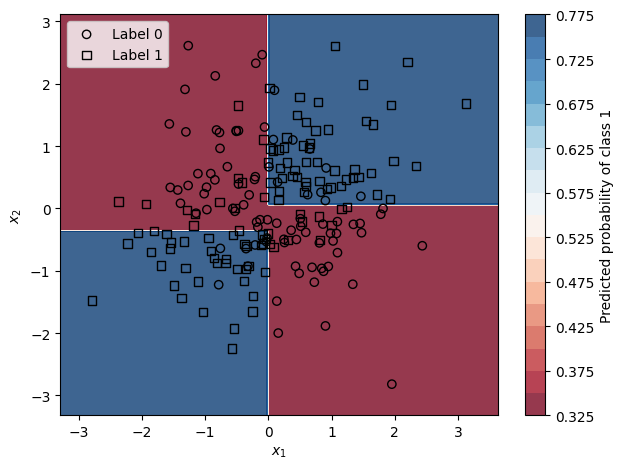

In [164]:
x0, x1 = x[:, 0], x[:, 1]

xx, yy = np.meshgrid(
    np.linspace(x0.min() - 0.5, x0.max() + 0.5, 200),
    np.linspace(x1.min() - 0.5, x1.max() + 0.5, 200)
)
grid = np.c_[xx.ravel(), yy.ravel()]
probs = classifier.predict_proba(grid)[:, 1].reshape(xx.shape)

cf = plt.contourf(xx, yy, probs, levels=20, cmap='RdBu', alpha=0.8)
for label, marker in zip([0, 1], ['o', 's']):
    idx = (y_class == label)
    plt.scatter(x[idx, 0], x[idx, 1], marker=marker,
                facecolors='none', edgecolors='k', label=f"Label {label}")

plt.colorbar(cf, label="Predicted probability of class 1")

plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend()
plt.tight_layout()
plt.show()